In [1]:
#Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved.
#SPDX-License-Identifier: MIT-0

In [19]:
#This cell installs the required libraries specified in the 'requirements.txt' file
!pip install -r requirements.txt --quiet

# load the data 

1. Read all files in the curated images directory and create a dataset and generate an identifer for each file 
2. for each record extract and enrich with metadata extracted via Bedrock 
3. call embeddings model for each image which we will use for semantic search purposes 

In [8]:
!unzip ./data/curated-images.zip

Archive:  ./data/curated-images.zip
   creating: curated-images/
  inflating: curated-images/2db10d9bca188e72.jpg  
  inflating: curated-images/0ae6ad98a59914fc.jpg  
  inflating: __MACOSX/curated-images/._0ae6ad98a59914fc.jpg  
  inflating: curated-images/19aa926f2f7d9782.jpg  
  inflating: __MACOSX/curated-images/._19aa926f2f7d9782.jpg  
  inflating: curated-images/1c542b393bbcbdfc.jpg  
  inflating: curated-images/0b8ae9cfd133e587.jpg  
  inflating: __MACOSX/curated-images/._0b8ae9cfd133e587.jpg  
  inflating: curated-images/0a41cda5f44baaf6.jpg  
  inflating: __MACOSX/curated-images/._0a41cda5f44baaf6.jpg  
  inflating: curated-images/0c9f9b713f229fba.jpg  
  inflating: curated-images/0b8613dd5b9d1700.jpg  
  inflating: __MACOSX/curated-images/._0b8613dd5b9d1700.jpg  
  inflating: curated-images/0cc8f7b633931d43.jpg  
  inflating: curated-images/0b9189a792a2ea3a.jpg  
  inflating: curated-images/0b6227bb06345402.jpg  
  inflating: __MACOSX/curated-images/._0b6227bb06345402.jpg  
  

In [1]:
import os
import pandas as pd

In [2]:
sample_images = []
images_dir = "./data/curated-images"

for filename in os.listdir(images_dir):
    f = os.path.join(images_dir, filename)
    # checking if it is a file
    if os.path.isfile(f):
        sample_images.append(
            {
                'image_id':filename,
                'path':f,
                'title':'',
                'description':'',
                'tags':[],
                'keywords':[],
                'embeddings':[]
            }
        )

df_images = pd.DataFrame(sample_images)

df_images.head()

,image_id,path,title,description,tags,keywords,embeddings
0,2db10d9bca188e72.jpg,./data/curated-images/2db10d9bca188e72.jpg,,,[],[],[]
1,0ae6ad98a59914fc.jpg,./data/curated-images/0ae6ad98a59914fc.jpg,,,[],[],[]
2,19aa926f2f7d9782.jpg,./data/curated-images/19aa926f2f7d9782.jpg,,,[],[],[]
3,1c542b393bbcbdfc.jpg,./data/curated-images/1c542b393bbcbdfc.jpg,,,[],[],[]
4,0b8ae9cfd133e587.jpg,./data/curated-images/0b8ae9cfd133e587.jpg,,,[],[],[]


In [3]:
# create some images using Titan image generator model - TBD
# fabricate a set of images 

In [4]:
## extract metadata with keywords, title, tags & description using bedrock Claude Haiku 

import sagemaker
import boto3
import json
import pprint as pp
import os
import shutil
import csv
import time
import pprint
import base64
from PIL import Image
from IPython.display import display

#get bedrock instances with boto3
bedrock = boto3.client('bedrock')
bedrock_client = boto3.client('bedrock-runtime')

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [192]:
# helper functions for generating metadata and creating some previews

modelid = 'anthropic.claude-3-sonnet-20240229-v1:0'


def image_to_base64(path):
    # Read reference image from file and encode as base64 strings.
    content_image = ""
    with open(path, "rb") as image_file:
        content_image = base64.b64encode(image_file.read()).decode('utf8')
    return content_image

def generate_metadata(bedrock_runtime, model_id, messages, max_tokens,top_p,temp):

    body=json.dumps(
        {
            "anthropic_version": "bedrock-2023-05-31",
            "max_tokens": max_tokens,
            "messages": messages,
            "temperature": temp,
            "top_p": top_p
        }  
    )  
    
    response = bedrock_runtime.invoke_model(body=body, modelId=model_id)
    response_body = json.loads(response.get('body').read())
    response_text = response_body["content"][0]["text"]    

    return response_text

def bulk_extract_metadata(df_images):
    return df_images    

def display_image(path):
    im = Image.open(path)
    plt.imshow(im)
    plt.figure(figsize=(10, 10))
    plt.show()

## Define and test the prompt to extract metadata

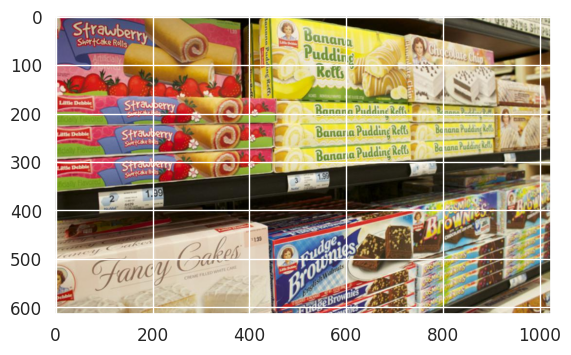

<Figure size 1000x1000 with 0 Axes>

In [230]:
# view the image we are trying to process
#display_image(df_images.loc[0,'path'])
test_image_path = './data/curated-images/0c8f84c8315e1d50.jpg'
#test_image_path = df_images.loc[0,'path']
display_image(test_image_path)

In [231]:
# prepapre the request payload for Claude 

# prepare the multimodal content message input for Claude 3 (separate json objects for image and text)
# define a prompt to get a title, description, tags, keywords from Claude 
# follow the costar principle (context, objective, style, tone, audience, response) 
prompt = """
You are a multimodal search engine metadata extractor. Your task is to carefully study the image, and extract tags, keywords, description, any text contained in the image, as well as forming a succinct title for the image.
Do not generated unwanted and uncessarily metadata, that will bloat the payload. Be detailed on various aspects of the image such as background, foreground and subject of the image.
If media contains no OCR texts then simply generate an empty string for it. 
Make necessary determination on the key category/theme of the image and generate keywords as appropriate. 

All metadata extracted is required to be professional for official use. Refrain from using informal language. 

The intended audience are various business users who will attempt to search based on keywords or describing in natural language what they are looking for. For this purpose generate a description the image and include finer details that can be used for search purposes alongisde keywords and tags. 

Output the metadata as well formed JSON as defined in the <example> XML tags. Do not include XML tags in the output.  

<example>
    {
        "title":"baseball player swinging bat",
        "description":"baseball player wearing team jersey swinging bat to score a home run. In the background there are cheering fans who are joyous and having a wonderful time. Stadium atmosphere seems electric.",
        "keywords":"baseball, sports, homerun, bat, player, jersey",
        "tags":"sports, stadium, baseball, crowd"
        "ocr_texts":"new york mets, mets, new york, richardson, 66"
    }
<example>
"""

def prepare_mm_input(path):
    # Read reference image from file and encode as base64 strings.
    content_image = image_to_base64(path)
    message_mm = [
        { "role": "user",
          "content": [
          {"type": "image","source": { "type": "base64","media_type":"image/jpeg","data": content_image}},
          {"type": "text","text": prompt}
          ]
        }
    ]
    return message_mm

In [232]:
# test the single image 
message_mm = prepare_mm_input(test_image_path)
response = generate_metadata(bedrock_client, model_id = modelid,messages=message_mm,max_tokens=512,temp=0.5,top_p=0.9)

In [233]:
print(response)


{
    "title": "Grocery Store Shelf with Baked Goods",
    "description": "The image shows a grocery store shelf stocked with various baked goods and dessert items. In the foreground, there are boxes of strawberry swirl cake rolls, banana pudding rolls, and chocolate cake rolls. The packaging displays images of the products and their respective flavors. In the background, there are packages of fancy cakes and fudge brownies. The shelves are well-organized, and the products are neatly arranged.",
    "keywords": "baked goods, desserts, grocery store, shelves, packaging, sweets, cakes, rolls, brownies, pudding",
    "tags": "food, retail, bakery, confectionery, supermarket",
    "ocr_texts": "Strawberry Sweet Cake Rolls, Banana Pudding Rolls, Chocolate Cake, Fancy Cakes, Fudge Brownies"
}


## Bulk metadata extraction 

now that we can verify keywords can be extracted let us process all the images in bulk 



In [12]:
df_images.head()

,image_id,path,title,description,tags,keywords,embeddings
0,2db10d9bca188e72.jpg,./data/curated-images/2db10d9bca188e72.jpg,,,[],[],[]
1,0ae6ad98a59914fc.jpg,./data/curated-images/0ae6ad98a59914fc.jpg,,,[],[],[]
2,19aa926f2f7d9782.jpg,./data/curated-images/19aa926f2f7d9782.jpg,,,[],[],[]
3,1c542b393bbcbdfc.jpg,./data/curated-images/1c542b393bbcbdfc.jpg,,,[],[],[]
4,0b8ae9cfd133e587.jpg,./data/curated-images/0b8ae9cfd133e587.jpg,,,[],[],[]


In [13]:
list_images = df_images.values.tolist()

from multiprocessing.dummy import Pool as ThreadPool 

#for idx, image in df_images[0:2].iterrows():
#    message_mm = prepare_mm_input(image['path'])
#    response = generate_metadata(bedrock_client, model_id = modelid,messages=message_mm,max_tokens=512,temp=0.5,top_p=0.9)
#    json_response = json.loads(response)
#    print(json_response['title'])
    # update the record python 
    #df_images.at[idx, 'title'] = json_response['title']
    #df_images.at[idx, 'description'] = json_response['description']
    #df_images.at[idx, 'keywords'] = json_response['keywords']
    #df_images.at[idx, 'tags'] = json_response['tags']

#df_images.head()

In [15]:
import time
from multiprocessing.dummy import Pool as ThreadPool 

pool = ThreadPool(5) 

# called by each thread
def get_metadata(item):
    message_mm = prepare_mm_input(item[1])
    response = generate_metadata(bedrock_client, model_id = modelid,messages=message_mm,max_tokens=512,temp=0.5,top_p=0.9)
    json_response = json.loads(response)
    response = {
        "image_id":item[0],
        "path":item[1],
        "title":json_response["title"],
        "description":json_response["description"],
        "keywords":json_response["keywords"],
        "tags":json_response["tags"]
    }
    return response

start_time = time.time()
results = pool.map(get_metadata, list_images)
duration = time.time() - start_time
print(f"Processed {len(list_images)} in {duration} seconds")

Processed 71 in 74.33816003799438 seconds


In [16]:
df_metadata = pd.DataFrame(results)
df_metadata.head()

,image_id,path,title,description,keywords,tags
0,2db10d9bca188e72.jpg,./data/curated-images/2db10d9bca188e72.jpg,Roaring Lion with Pride on Savannah,"The image depicts a majestic lion, with a full...","lion, roar, savannah, wildlife, predator, big ...","animal, nature, safari, Africa, feline, carniv..."
1,0ae6ad98a59914fc.jpg,./data/curated-images/0ae6ad98a59914fc.jpg,Short Track Speed Skating Competition at Winte...,The image depicts a short track speed skating ...,"short track speed skating, Winter Olympics, ic...","sports, Olympics, winter sports, speed skating..."
2,19aa926f2f7d9782.jpg,./data/curated-images/19aa926f2f7d9782.jpg,Baseball Player Taking a Swing,The image depicts a baseball player in a blue ...,"baseball, sports, athlete, batting, stadium, g...","baseball, sports, athlete, batting, stadium, game"
3,1c542b393bbcbdfc.jpg,./data/curated-images/1c542b393bbcbdfc.jpg,Majestic Lion Portrait,This image captures a striking close-up portra...,"lion, wildlife, portrait, feline, predator, ma...","animal, nature, safari, big cat, carnivore, ki..."
4,0b8ae9cfd133e587.jpg,./data/curated-images/0b8ae9cfd133e587.jpg,Colorful Amusement Park Swing Ride,The image depicts a massive and ornately decor...,"amusement park, swing ride, carnival, fair, ri...","amusement park, rides, carnival, fair, enterta..."


## Generate Embeddings

Use titan multi-modal embedding model (titan-embed-image-v1) to create embeddings of the images as an alternative mechanism/method to carry out smart search. 



In [94]:
#adding our utils library to sys path
import sys
sys.path.append("./src/helpers/")
from utils import *

In [26]:
multimodal_embeddings_img = []

for idx, image in df_metadata.iterrows():
    embedding = get_titan_multimodal_embedding(image_path=image['path'], dimension=1024)["embedding"]
    multimodal_embeddings_img.append(embedding)

df_metadata_all = df_metadata.assign(embeddings=multimodal_embeddings_img)

In [28]:
df_metadata_all.head()

,image_id,path,title,description,keywords,tags,embeddings
0,2db10d9bca188e72.jpg,./data/curated-images/2db10d9bca188e72.jpg,Roaring Lion with Pride on Savannah,"The image depicts a majestic lion, with a full...","lion, roar, savannah, wildlife, predator, big ...","animal, nature, safari, Africa, feline, carniv...","[-0.030930687, 0.025374275, -0.027411627, -0.0..."
1,0ae6ad98a59914fc.jpg,./data/curated-images/0ae6ad98a59914fc.jpg,Short Track Speed Skating Competition at Winte...,The image depicts a short track speed skating ...,"short track speed skating, Winter Olympics, ic...","sports, Olympics, winter sports, speed skating...","[0.037624072, -0.008849997, 0.01454921, -0.028..."
2,19aa926f2f7d9782.jpg,./data/curated-images/19aa926f2f7d9782.jpg,Baseball Player Taking a Swing,The image depicts a baseball player in a blue ...,"baseball, sports, athlete, batting, stadium, g...","baseball, sports, athlete, batting, stadium, game","[0.03435463, 0.019374413, -0.025066897, -0.023..."
3,1c542b393bbcbdfc.jpg,./data/curated-images/1c542b393bbcbdfc.jpg,Majestic Lion Portrait,This image captures a striking close-up portra...,"lion, wildlife, portrait, feline, predator, ma...","animal, nature, safari, big cat, carnivore, ki...","[-0.008380676, 0.017047057, -0.017999405, -0.0..."
4,0b8ae9cfd133e587.jpg,./data/curated-images/0b8ae9cfd133e587.jpg,Colorful Amusement Park Swing Ride,The image depicts a massive and ornately decor...,"amusement park, swing ride, carnival, fair, ri...","amusement park, rides, carnival, fair, enterta...","[-0.004559835, -0.015294446, -0.016339408, 0.0..."


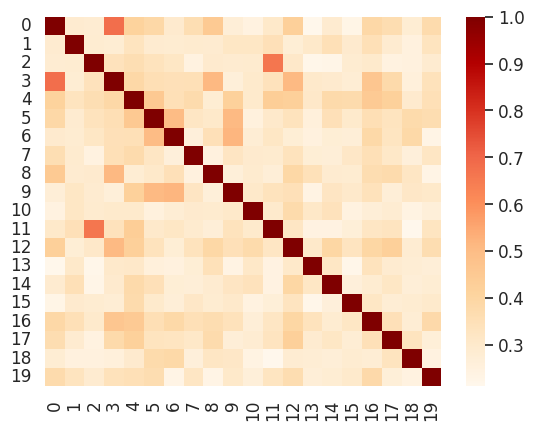

In [29]:
# generate a similarty heatmap of 20 images
plot_similarity_heatmap(multimodal_embeddings_img[:20], multimodal_embeddings_img[:20])

## Vector Datastore 

1. Create index to hold vector as well as metadata extracted via LLM

2. Load the data into the index 

3. carry out search using Similarity search as well as keyword search 

4. run comparison on the different types of search

### create the vector store 
Before creating the new vector search collection and index, we must first create three associated OpenSearch policies: encryption security policy, network security policy, and data access policy.

In [55]:
identity_arn = ""

try:
    # Get the execution role ARN
    identity_arn = sagemaker.get_execution_role()
    
except Exception as e:
    print("Not a sagemaker role, trying to retrieve the user identity")
    # Create an STS client
    sts_client = boto3.client('sts')

    # Get the caller identity
    caller_identity = sts_client.get_caller_identity()
    identity_arn = caller_identity['Arn']

print(f"Identity ARN:{identity_arn}")

Identity ARN:arn:aws:iam::207390309313:role/service-role/AmazonSageMaker-ExecutionRole-20220409T200590


In [33]:
from opensearchpy import OpenSearch, RequestsHttpConnection, AWSV4SignerAuth, helpers
# getting boto3 clients for required AWS services
sts_client = boto3.client('sts')
s3_client = boto3.client('s3')
aoss_client = boto3.client('opensearchserverless')

session = boto3.session.Session()
region_name = session.region_name
account_id = sts_client.get_caller_identity()["Account"]
region, account_id

# Create a SageMaker session
sagemaker_role_arn = sagemaker.get_execution_role()
sagemaker_role_arn

'arn:aws:iam::207390309313:role/service-role/AmazonSageMaker-ExecutionRole-20220409T200590'

In [68]:
# Create an IAM client
iam = boto3.client('iam')

# Define the policy document
policy_document = {
    "Version": "2012-10-17",
    "Statement": [
        {
            "Effect": "Allow",
            "Action": "aoss:*",
            "Resource": "*"
        }
    ]
}

# Create the IAM policy
aossAccessPolicy = iam.create_policy(
    PolicyName='AOSSAccessPolicy',
    PolicyDocument=json.dumps(policy_document)
)


aossAccessPolicyArn = aossAccessPolicy["Policy"]["Arn"]

EntityAlreadyExistsException: An error occurred (EntityAlreadyExists) when calling the CreatePolicy operation: A policy called AOSSAccessPolicy already exists. Duplicate names are not allowed.

In [70]:
#wait for the policy to be created
#time.sleep(10)

# Check if the identity ARN is for a user or a role
try:
    # Try to get the user information
    user = iam.get_user(UserName=sagemaker_role_arn.split('/')[-1])
    print(f"The identity ARN '{sagemaker_role_arn}' is for a user.")

    # Attach the policy to the user
    iam.attach_user_policy(
        UserName=user['User']['UserName'],
        PolicyArn=aossAccessPolicyArn
    )
except iam.exceptions.NoSuchEntityException:
    # If the identity ARN is not for a user, it must be for a role
    print(f"The identity ARN '{sagemaker_role_arn}' is for a role.")

    # Attach the policy to the role
    iam.attach_role_policy(
        RoleName=sagemaker_role_arn.split('/')[-1],
        PolicyArn=aossAccessPolicyArn
    )

The identity ARN 'arn:aws:iam::207390309313:role/service-role/AmazonSageMaker-ExecutionRole-20220409T200590' is for a role.


In [75]:
# data access policy for OSS

collection_name='media-search'
# Create an OpenSearch Serverless client
opss_client = boto3.client('opensearchserverless')

data_access_policy = json.dumps([
      {
        "Rules": [
          {
            "Resource": [
              f"collection/{collection_name}"
            ],
            "Permission": [
              "aoss:CreateCollectionItems",
              "aoss:DeleteCollectionItems",
              "aoss:UpdateCollectionItems",
              "aoss:DescribeCollectionItems"
            ],
            "ResourceType": "collection"
          },
          {
            "Resource": [
              f"index/{collection_name}/*"
            ],
            "Permission": [
              "aoss:CreateIndex",
              "aoss:DeleteIndex",
              "aoss:UpdateIndex",
              "aoss:DescribeIndex",
              "aoss:ReadDocument",
              "aoss:WriteDocument"
            ],
            "ResourceType": "index"
          }
        ],
        "Principal": [
          identity_arn
        ],
        "Description": "data-access-rule"
      }
    ], indent=2)

data_access_policy_name_nb = f"{collection_name}-policy-notebook"

# Create the data access policy
response = opss_client.create_access_policy(
    description='Data access policy for semantic search collection',
    name=data_access_policy_name_nb,
    policy=str(data_access_policy),
    type='data'
)

print(response)

{'accessPolicyDetail': {'createdDate': 1723618873377, 'description': 'Data access policy for semantic search collection', 'lastModifiedDate': 1723618873377, 'name': 'media-search-policy-notebook', 'policy': [{'Rules': [{'Resource': ['collection/media-search'], 'Permission': ['aoss:CreateCollectionItems', 'aoss:DeleteCollectionItems', 'aoss:UpdateCollectionItems', 'aoss:DescribeCollectionItems'], 'ResourceType': 'collection'}, {'Resource': ['index/media-search/*'], 'Permission': ['aoss:CreateIndex', 'aoss:DeleteIndex', 'aoss:UpdateIndex', 'aoss:DescribeIndex', 'aoss:ReadDocument', 'aoss:WriteDocument'], 'ResourceType': 'index'}], 'Principal': ['arn:aws:iam::207390309313:role/service-role/AmazonSageMaker-ExecutionRole-20220409T200590'], 'Description': 'data-access-rule'}], 'policyVersion': 'MTcyMzYxODg3MzM3N18x', 'type': 'data'}, 'ResponseMetadata': {'RequestId': 'fbc7a969-7141-4fc1-b0bb-66d57284a994', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': 'fbc7a969-7141-4fc1-b0bb-66

In [77]:
encryption_policy_name = f"{collection_name}-sp-notebook"

encryption_policy = aoss_client.create_security_policy(
    name=encryption_policy_name,
    policy=json.dumps(
        {
            'Rules': [{'Resource': ['collection/' + collection_name],
                       'ResourceType': 'collection'}],
            'AWSOwnedKey': True
        }),
        type='encryption'
    )


In [78]:
network_policy_name = f"{collection_name}-np-notebook"
network_policy = aoss_client.create_security_policy(
    name=network_policy_name,
    policy=json.dumps(
        [
            {'Rules': [{'Resource': ['collection/' + collection_name],
                        'ResourceType': 'collection'}],
             'AllowFromPublic': True}
        ]),
        type='network'
    )

In [79]:
# create the collection of type vector search 
collection = aoss_client.create_collection(name=collection_name,type='VECTORSEARCH')

In [80]:
### Setup the OSS index using KNN settings 

collection_id = collection['createCollectionDetail']['id']
host = collection_id + '.' + region_name + '.aoss.amazonaws.com'
print(host)

603z217wer26ar7wkrb2.us-east-1.aoss.amazonaws.com


In [84]:
service = 'aoss'
credentials = boto3.Session().get_credentials()
awsauth = AWSV4SignerAuth(credentials, region_name, service)

index_name = 'smart-search-index'
index_body = {
   "settings": {
      "index.knn": "true"
   },
   "mappings": {
      "properties": {
          "image_vector": {
              "type": "knn_vector",
              "dimension": 1024 # Embedding size for Amanon Titan Multimodal Embedding G1 model, it is 1,024 (default), 384, 256
          },
          "image_id" : {"type": "text"},
          "path": {"type": "text"},
          "title": {"type": "text"},
          "description": {"type": "text"},
          "keywords": {"type": "text"},
          "tags": {"type": "text"}
      }
   }
}
# Build the OpenSearch client
oss_client = OpenSearch(
    hosts=[{'host': host, 'port': 443}],
    http_auth=awsauth,
    use_ssl=True,
    verify_certs=True,
    connection_class=RequestsHttpConnection,
    timeout=300
)
# # It can take up to a minute for data access rules to be enforced
time.sleep(60)

In [85]:
# We would get an index already exists exception if the index already exists, and that is fine.
try:
    response = oss_client.indices.create(index_name, body=index_body)
    print(f"response received for the create index -> {response}")
except Exception as e:
    print(f"error in creating index={index_name}, exception={e}")

response received for the create index -> {'acknowledged': True, 'shards_acknowledged': True, 'index': 'smart-search-index'}


In [ ]:
# deleting indices
# aoss_client.indices.delete(index=index_name)

In [87]:
#display information on the index you just created

# Get index mapping
response = oss_client.indices.get_mapping(index=index_name)
pp.pprint(response) 

# Get index settings
response = oss_client.indices.get_settings(index=index_name)
pp.pprint(response)

# Get index aliases
response = oss_client.indices.get_alias(index=index_name) 
pp.pprint(response)

{'smart-search-index': {'mappings': {'properties': {'description': {'type': 'text'},
                                                    'image_id': {'type': 'text'},
                                                    'image_vector': {'dimension': 1024,
                                                                     'type': 'knn_vector'},
                                                    'keywords': {'type': 'text'},
                                                    'path': {'type': 'text'},
                                                    'tags': {'type': 'text'},
                                                    'title': {'type': 'text'}}}}}
{'smart-search-index': {'settings': {'index': {'knn': 'true',
                                               'number_of_replicas': '0',
                                               'number_of_shards': '2',
                                               'provided_name': 'smart-search-index',
                                       

### Load embeddings in OSS

In [88]:
%%time
from tqdm import tqdm
import tqdm.notebook as tq

for idx, record in tq.tqdm(df_metadata_all.iterrows(), total=len(df_metadata_all)):
    document = {
        'image_vector': df_metadata_all['embeddings'][idx],
        "description":   df_metadata_all['description'][idx],
        "image_id" : df_metadata_all['image_id'][idx],
        "image_url": df_metadata_all['path'][idx],
        "title": df_metadata_all['title'][idx],
        "keywords": df_metadata_all['keywords'][idx],
        "tags": df_metadata_all['tags'][idx],
    }
    response = oss_client.index(
        index = index_name,
        body = document
    )

  0%|          | 0/71 [00:00<?, ?it/s]

CPU times: user 395 ms, sys: 12.3 ms, total: 407 ms
Wall time: 22.5 s


## Perform Search

In [213]:
# reload 
%load_ext autoreload
%autoreload 2
    
from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [165]:
search_term = "baseball bat swing"

In [166]:
# lexical search augmented with enrichment via Gen AI
query = {
    "query": {
        "match": {
            "description": {
                "query": search_term
            }
        }
    },
    "_source": {
        "exclude": ["image_vector"],
    },
    "size": 10
}

search_response = oss_client.search(body=query, index=index_name)


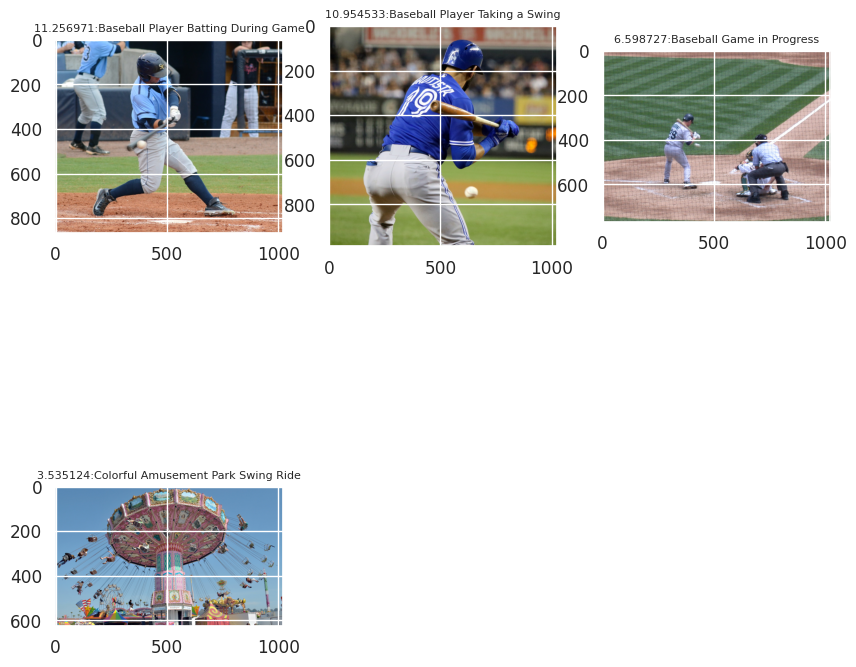

In [167]:
display_results(search_response, df_metadata_all)

In [168]:
# semantic search using text embedding to search 

similar_items = find_similar_items_from_query(query_prompt = search_term, k=2, num_results=10, index_name=index_name, dataset = df_metadata_all, 
                                   open_search_client = oss_client, image_root_path=None)

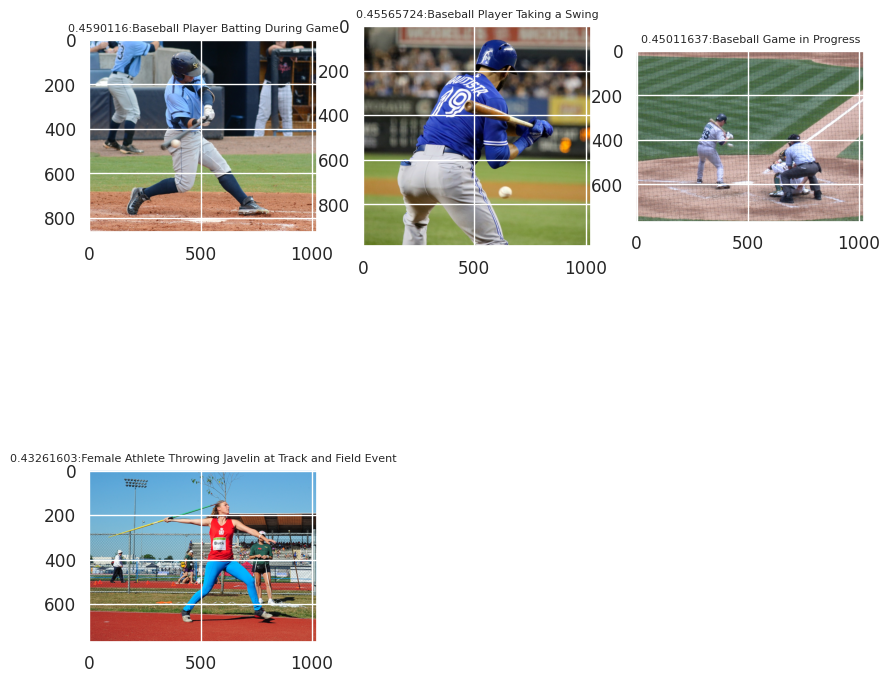

In [169]:
display_images(similar_items)

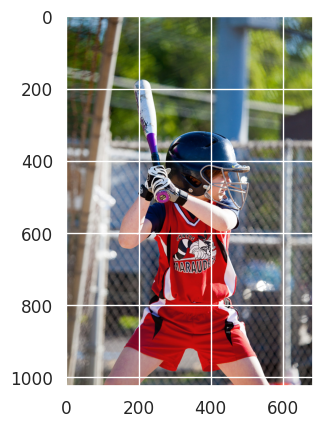

<Figure size 1000x1000 with 0 Axes>

In [204]:
# semantic search using image as source 
# view the image we are trying to search with - for this example we will use the same baseball swing image
search_image_path='./data/3c06d149c8027e71.jpg'
display_image(search_image_path)

In [205]:
similar_items = find_similar_items_from_image(image_path = search_image_path, k=2, num_results=10, index_name=index_name, dataset = df_metadata_all, 
                                   open_search_client = oss_client, image_root_path=None)



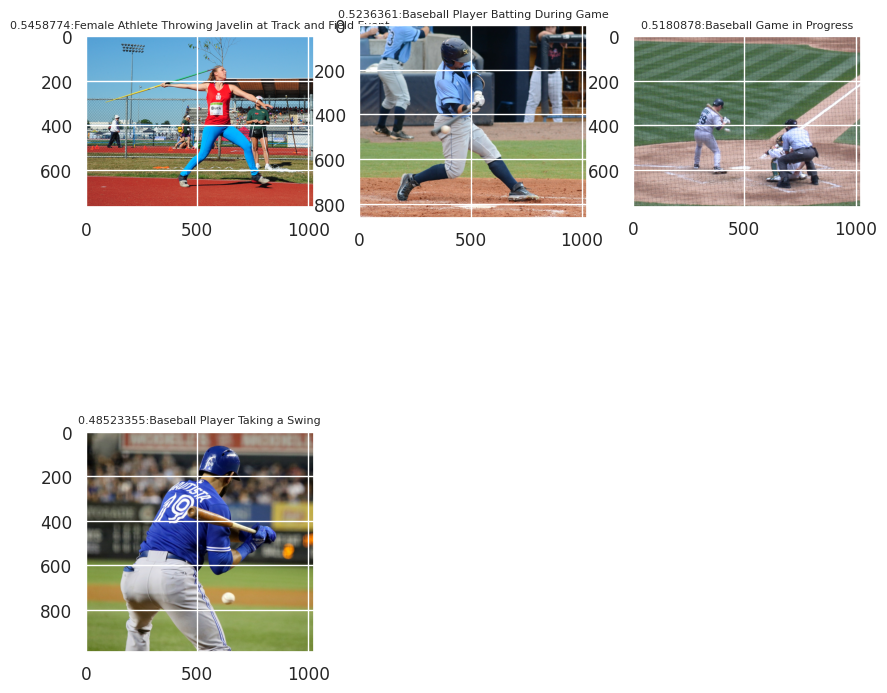

In [206]:
display_images(similar_items)

In [220]:
# Semantic search using image + text 
search_term = "baseball player swinging bat"
similar_items = find_similar_items_from_image_and_text(image_path = search_image_path, query_prompt = search_term, k=2, num_results=10, index_name=index_name, dataset = df_metadata_all, 
                                   open_search_client = oss_client, image_root_path=None)



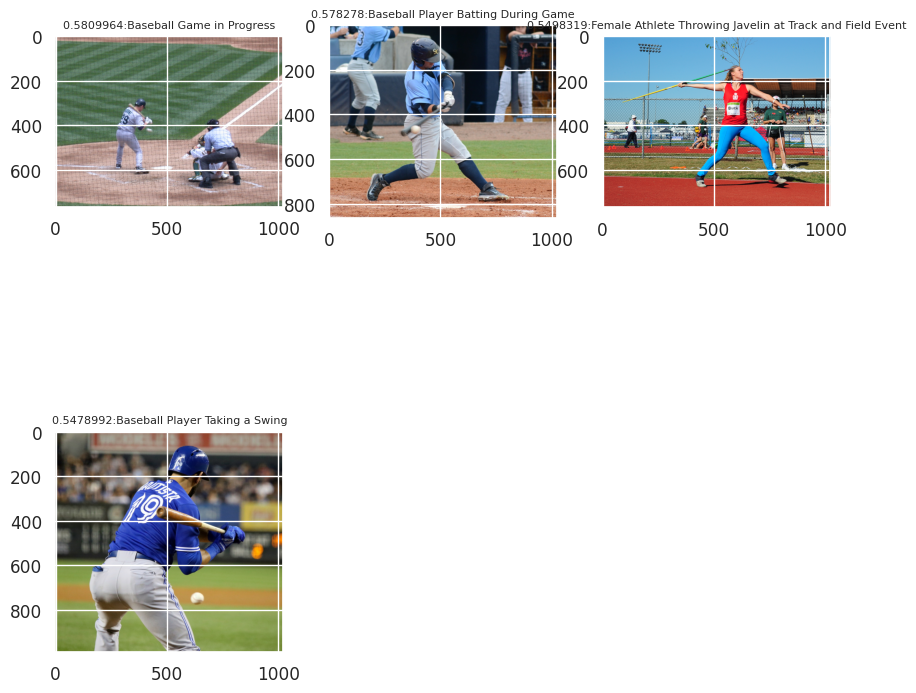

In [221]:
display_images(similar_items)

In [ ]:
# Hybrid Search 